In [1]:
import bcolz
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import cv2
import os

Init Plugin
Init Graph Optimizer
Init Kernel


In [251]:
import modules.evaluations as eval

In [46]:
path = './download_testset/'
name = 'lfw_align_112/lfw'
img_path = os.path.join(os.path.join(path, name), '__0.blp')

In [6]:
carray, issame = eval.get_val_pair(path, name)

In [9]:
carray.shape, issame.shape

((12000, 3, 112, 112), (6000,))

In [155]:
issame[:5]

array([ True,  True,  True,  True,  True])

In [76]:
def check_img(index1, index2):
    carray_t = carray[index1].swapaxes(0, 2).swapaxes(0, 1)
    carray_t = cv2.cvtColor(carray_t, cv2.COLOR_BGR2RGB)
    carray_t2 = carray[index2].swapaxes(0, 2).swapaxes(0, 1)
    carray_t2 = cv2.cvtColor(carray_t2, cv2.COLOR_BGR2RGB)
    
    # image_0 = Image.fromarray(carray[0])
    # image_0.save('my.png')
    # image_0.show()
    print(carray_t.shape, carray_t2.shape)
    print(issame[index1 // 2])
    plt.subplot(121)
    plt.imshow(carray_t)
    plt.subplot(122)
    plt.imshow(carray_t2)
    plt.axis('off')
    plt.show()

(112, 112, 3) (112, 112, 3)
True


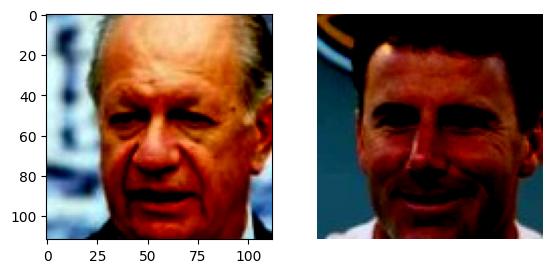

In [201]:
check_img(450, 456)

(112, 112, 3) (112, 112, 3)
True


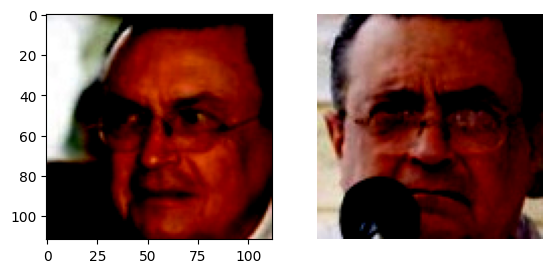

In [249]:
check_img()

Test code for notebook

utils.py

In [114]:
from absl import logging
import yaml

In [115]:
def set_memory_growth():

    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices(
                    'GPU')
                logging.info(
                    "Detect {} Physical GPUs, {} Logical GPUs.".format(
                        len(gpus), len(logical_gpus)))
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            logging.info(e)

In [116]:
def load_yaml(load_path):

    """load yaml file"""
    with open(load_path, 'r') as f:
        loaded = yaml.load(f, Loader=yaml.Loader)

    return loaded

In [117]:
def l2_norm(x, axis=1):
    """l2 norm"""
    norm = np.linalg.norm(x, axis=axis, keepdims=True)
    output = x / norm

    return output

layers.py

In [118]:
import math

In [119]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
    """Make trainable=False freeze BN for real (the og version is sad).
       ref: https://github.com/zzh8829/yolov3-tf2
    """
    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

In [120]:
class ArcMarginPenaltyLogists(tf.keras.layers.Layer):
    """ArcMarginPenaltyLogists"""
    def __init__(self, num_classes, margin=0.5, logist_scale=64, **kwargs):
        super(ArcMarginPenaltyLogists, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.margin = margin
        self.logist_scale = logist_scale

    def build(self, input_shape):
        self.w = self.add_variable(
            "weights", shape=[int(input_shape[-1]), self.num_classes])
        self.cos_m = tf.identity(math.cos(self.margin), name='cos_m')
        self.sin_m = tf.identity(math.sin(self.margin), name='sin_m')
        self.th = tf.identity(math.cos(math.pi - self.margin), name='th')
        self.mm = tf.multiply(self.sin_m, self.margin, name='mm')

    def call(self, embds, labels):
        normed_embds = tf.nn.l2_normalize(embds, axis=1, name='normed_embd')
        normed_w = tf.nn.l2_normalize(self.w, axis=0, name='normed_weights')

        cos_t = tf.matmul(normed_embds, normed_w, name='cos_t')
        sin_t = tf.sqrt(1. - cos_t ** 2, name='sin_t')

        cos_mt = tf.subtract(
            cos_t * self.cos_m, sin_t * self.sin_m, name='cos_mt')

        cos_mt = tf.where(cos_t > self.th, cos_mt, cos_t - self.mm)

        mask = tf.one_hot(tf.cast(labels, tf.int32), depth=self.num_classes,
                          name='one_hot_mask')

        logists = tf.where(mask == 1., cos_mt, cos_t)
        logists = tf.multiply(logists, self.logist_scale, 'arcface_logist')

        return logists


models.py

In [121]:
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Input,
)
from tensorflow.keras.applications import (
    MobileNetV2,
    ResNet50
)

In [122]:
def _regularizer(weights_decay=5e-4):
    return tf.keras.regularizers.l2(weights_decay)

In [123]:
def Backbone(backbone_type='ResNet50', use_pretrain=True):
    """Backbone Model"""
    weights = None
    if use_pretrain:
        weights = 'imagenet'

    def backbone(x_in):
        if backbone_type == 'ResNet50':
            return ResNet50(input_shape=x_in.shape[1:], include_top=False,
                            weights=weights)(x_in)
        elif backbone_type == 'MobileNetV2':
            return MobileNetV2(input_shape=x_in.shape[1:], include_top=False,
                               weights=weights)(x_in)
        else:
            raise TypeError('backbone_type error!')
    return backbone

In [124]:
def OutputLayer(embd_shape, w_decay=5e-4, name='OutputLayer'):
    """Output Later"""
    def output_layer(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = BatchNormalization()(x)
        x = Dropout(rate=0.5)(x)
        x = Flatten()(x)
        x = Dense(embd_shape, kernel_regularizer=_regularizer(w_decay))(x)
        x = BatchNormalization()(x)
        return Model(inputs, x, name=name)(x_in)
    return output_layer

In [125]:

def ArcHead(num_classes, margin=0.5, logist_scale=64, name='ArcHead'):
    """Arc Head"""
    def arc_head(x_in, y_in):
        x = inputs1 = Input(x_in.shape[1:])
        y = Input(y_in.shape[1:])
        x = ArcMarginPenaltyLogists(num_classes=num_classes,
                                    margin=margin,
                                    logist_scale=logist_scale)(x, y)
        return Model((inputs1, y), x, name=name)((x_in, y_in))
    return arc_head

In [126]:
def NormHead(num_classes, w_decay=5e-4, name='NormHead'):
    """Norm Head"""
    def norm_head(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = Dense(num_classes, kernel_regularizer=_regularizer(w_decay))(x)
        return Model(inputs, x, name=name)(x_in)
    return norm_head

In [127]:
def ArcFaceModel(size=None, channels=3, num_classes=None, name='arcface_model',
                 margin=0.5, logist_scale=64, embd_shape=512,
                 head_type='ArcHead', backbone_type='ResNet50',
                 w_decay=5e-4, use_pretrain=True, training=False):
    """Arc Face Model"""
    x = inputs = Input([size, size, channels], name='input_image')

    x = Backbone(backbone_type=backbone_type, use_pretrain=use_pretrain)(x)

    embds = OutputLayer(embd_shape, w_decay=w_decay)(x)

    if training:
        assert num_classes is not None
        labels = Input([], name='label')
        if head_type == 'ArcHead':
            logist = ArcHead(num_classes=num_classes, margin=margin,
                             logist_scale=logist_scale)(embds, labels)
        else:
            logist = NormHead(num_classes=num_classes, w_decay=w_decay)(embds)
        return Model((inputs, labels), logist, name=name)
    else:
        return Model(inputs, embds, name=name)

evaluation.py

In [128]:
import tqdm
from sklearn.model_selection import KFold

In [129]:
def test_registration(registered_embed, test_embed, threshold): #LYJ
    # 1. get model embedding of each img
    # 2. get diff
    assert (registered_embed.shape[0] == test_embed.shape[0])
    assert (registered_embed.shape[1] == test_embed.shape[1])

    diff = np.subtract(registered_embed, test_embed)
    dist = np.sum(np.square(diff), 1)

    # 3. calculate the result
    predict_issame = np.less(dist, threshold)

    return predict_issame, dist #Boolean, Probability

In [231]:
def get_val_pair(path, name, binary=True):
    img_dir = os.path.join(path, name)
    if binary:
        arr = bcolz.carray(rootdir=img_dir, mode='r')
    else:
        arr = np.empty((0, 3, 112, 112))
        img_list = sorted([file for file in os.listdir(img_dir) if file.split('.')[-1] == 'png'])
        for img_name in img_list:
            img_path = os.path.join(img_dir, img_name)
            print(img_path)
            img_arr = cv2.resize(cv2.imread(img_path), (112, 112)).swapaxes(0, 2).swapaxes(1, 2) #차원, 행, 열
            img_arr = np.expand_dims(img_arr, 0)
            # img_arr_toshow = cv2.cvtColor(img_arr[0].swapaxes(0, 2).swapaxes(0, 1), cv2.COLOR_BGR2RGB)
            # plt.imshow(img_arr_toshow)
            # plt.show()
            # print(arr.shape, img_arr.shape)
            arr = np.concatenate([arr, img_arr], axis=0)
    issame = np.load('{}/{}_list.npy'.format(path, name))

    return arr, issame

In [248]:
li = np.load('./download_testset/v3_dataset/v3_list.npy')
print(len(li))
# np.save('./download_testset/test_img/test_list.npy', (np.array([True, True, False])))

2752


In [246]:
cv2.imread('./download_testset/v3_dataset/v3/0007_0000888_0007_0000888_script_3.jpg').shape

(180, 150, 3)

In [233]:
arr, same = get_val_pair('./download_testset', 'test_img/test', binary=False)
print(arr.shape, same.shape)

./download_testset/test_img/test/test_0.png
./download_testset/test_img/test/test_1.png
./download_testset/test_img/test/test_420.png
./download_testset/test_img/test/test_421.png
./download_testset/test_img/test/test_450.png
./download_testset/test_img/test/test_456.png
(6, 3, 112, 112) (3,)


In [131]:
def get_val_data(data_path):
    """get validation data"""
    lfw, lfw_issame = get_val_pair(data_path, 'lfw_align_112/lfw')
    agedb_30, agedb_30_issame = get_val_pair(data_path,
                                             'agedb_align_112/agedb_30')
    cfp_fp, cfp_fp_issame = get_val_pair(data_path, 'cfp_align_112/cfp_fp')

    return lfw, agedb_30, cfp_fp, lfw_issame, agedb_30_issame, cfp_fp_issame


In [132]:
def ccrop_batch(imgs):
    assert len(imgs.shape) == 4
    resized_imgs = np.array([cv2.resize(img, (128, 128)) for img in imgs])
    ccropped_imgs = resized_imgs[:, 8:-8, 8:-8, :]

    return ccropped_imgs

In [133]:
def hflip_batch(imgs):
    assert len(imgs.shape) == 4
    return imgs[:, :, ::-1, :]

In [134]:
def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame),
                               np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    acc = float(tp + tn) / dist.size
    return tpr, fpr, acc

In [152]:
def vis_ROC_curve(tprs, fprs, tprs_shape, thresholds):
    #1. get ROC information from multiple threshold results
    print(tprs_shape)
    print(tprs.shape, fprs.shape, thresholds.shape)
    # threshold: 0 to 4, 400 threshold
    # tprs, fprs: K-fold * 400 thres

    #2. plot ROC curve
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
    idx = 0
    for k_tprs, k_fprs in zip(tprs, fprs):
        print('[*] K-fold ' + str(idx) + ' result')
        row = idx // 5
        col = idx % 5
        ax = axes[row][col]
        ax.scatter(x=k_fprs, y=k_tprs)
        idx += 1
        # plt.figure(figsize=(5, 5))
        # plt.scatter(x=k_tprs, y=k_fprs)
    plt.show()
    return

In [136]:
def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame,
                  nrof_folds=10):
    assert (embeddings1.shape[0] == embeddings2.shape[0])
    assert (embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    tprs = np.zeros((nrof_folds, nrof_thresholds))
    fprs = np.zeros((nrof_folds, nrof_thresholds))
    accuracy = np.zeros((nrof_folds))
    best_thresholds = np.zeros((nrof_folds))
    indices = np.arange(nrof_pairs)

    diff = np.subtract(embeddings1, embeddings2)
    dist = np.sum(np.square(diff), 1)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(
                threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)

        best_thresholds[fold_idx] = thresholds[best_threshold_index]
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx, threshold_idx], fprs[fold_idx, threshold_idx], _ = \
                calculate_accuracy(threshold,
                                   dist[test_set],
                                   actual_issame[test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(
            thresholds[best_threshold_index],
            dist[test_set],
            actual_issame[test_set])

    tpr = np.mean(tprs, 0)
    fpr = np.mean(fprs, 0)

    vis_ROC_curve(tprs, fprs, (nrof_folds, nrof_thresholds), thresholds)
    return tpr, fpr, accuracy, best_thresholds

In [137]:
def evaluate(embeddings, actual_issame, nrof_folds=10):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 4, 0.01)
    embeddings1 = embeddings[0::2] # 0, 2, 4, 6, 8 LYJ
    embeddings2 = embeddings[1::2] # 1, 3, 5, 7, 9 LYJ
    tpr, fpr, accuracy, best_thresholds = calculate_roc(
        thresholds, embeddings1, embeddings2, np.asarray(actual_issame),
        nrof_folds=nrof_folds)

    return tpr, fpr, accuracy, best_thresholds


In [138]:
def perform_val(embedding_size, batch_size, model,
                carray, issame, nrof_folds=10, is_ccrop=False, is_flip=True):
    """perform val"""
    embeddings = np.zeros([len(carray), embedding_size])

    for idx in tqdm.tqdm(range(0, len(carray), batch_size)):
        batch = carray[idx:idx + batch_size]
        batch = np.transpose(batch, [0, 2, 3, 1]) * 0.5 + 0.5
        batch = batch[:, :, :, ::-1]  # convert BGR to RGB

        if is_ccrop:
            batch = ccrop_batch(batch)
        if is_flip:
            fliped = hflip_batch(batch)
            emb_batch = model(batch) + model(fliped)
            embeddings[idx:idx + batch_size] = l2_norm(emb_batch)
        else:
            emb_batch = model(batch)
            embeddings[idx:idx + batch_size] = l2_norm(emb_batch)

    tpr, fpr, accuracy, best_thresholds = evaluate(
        embeddings, issame, nrof_folds)

    return accuracy.mean(), best_thresholds.mean()

test.py

In [139]:
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import os
import numpy as np
import tensorflow as tf

In [145]:
cfg_path = './configs/arc_res50.yaml'
gpu = '0' #which gpu to use
img_path = '' #path to input image './test_0.png'
registered_img_path = './test_420.png' #path to registered image


In [146]:
def test():
    
    
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu

    logger = tf.get_logger()
    logger.disabled = True
    logger.setLevel(logging.FATAL)
    set_memory_growth()

    cfg = load_yaml(cfg_path)

    model = ArcFaceModel(size=cfg['input_size'],
                         backbone_type=cfg['backbone_type'],
                         training=False)

    ckpt_path = tf.train.latest_checkpoint('./checkpoints/' + cfg['sub_name'])
    if ckpt_path is not None:
        print("[*] load ckpt from {}".format(ckpt_path))
        model.load_weights(ckpt_path)
    else:
        print("[*] Cannot find ckpt from {}.".format(ckpt_path))
        exit()

    if registered_img_path: #LYJ
        print("[*] Encode {} to ./output_embeds.npy".format(registered_img_path))
        reg_img = cv2.imread(registered_img_path)
        reg_img = cv2.resize(reg_img, (cfg['input_size'], cfg['input_size']))
        reg_img = reg_img.astype(np.float32) / 255.
        reg_img = cv2.cvtColor(reg_img, cv2.COLOR_BGR2RGB)
        if len(reg_img.shape) == 3:
            reg_img = np.expand_dims(reg_img, 0)
        reg_embeds = l2_norm(model(reg_img))

        np.save('./{}_output_embeds.npy'.format(registered_img_path), reg_embeds)
        print('[*] Image {} registered'.format(registered_img_path)) #LYJ
    
    if img_path:
        print("[*] Encode {} to ./output_embeds.npy".format(img_path))
        img = cv2.imread(img_path)
        img = cv2.resize(img, (cfg['input_size'], cfg['input_size']))
        img = img.astype(np.float32) / 255.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if len(img.shape) == 3:
            img = np.expand_dims(img, 0)
        embeds = l2_norm(model(img))

        # np.save('./output_embeds.npy', embeds)
        print(embeds.shape)
        pred_result, dist = test_registration(reg_embeds, embeds, threshold=1.34) # LFW 1.34 / AgeDB30 1.43 / CFP-FP 1.53
        print('[*] Test img {} is registered: {} (dist: {})'.format(img_path, pred_result, dist))
    else:
        print("[*] Loading LFW, AgeDB30 and CFP-FP...")
        lfw, agedb_30, cfp_fp, lfw_issame, agedb_30_issame, cfp_fp_issame = \
            get_val_data(cfg['test_dataset'])

        print("[*] Perform Evaluation on LFW...")
        acc_lfw, best_th = perform_val(
            cfg['embd_shape'], cfg['batch_size'], model, lfw, lfw_issame,
            is_ccrop=cfg['is_ccrop'])
        print("    acc {:.4f}, th: {:.2f}".format(acc_lfw, best_th))

        print("[*] Perform Evaluation on AgeDB30...")
        acc_agedb30, best_th = perform_val(
            cfg['embd_shape'], cfg['batch_size'], model, agedb_30,
            agedb_30_issame, is_ccrop=cfg['is_ccrop'])
        print("    acc {:.4f}, th: {:.2f}".format(acc_agedb30, best_th))

        print("[*] Perform Evaluation on CFP-FP...")
        acc_cfp_fp, best_th = perform_val(
            cfg['embd_shape'], cfg['batch_size'], model, cfp_fp, cfp_fp_issame,
            is_ccrop=cfg['is_ccrop'])
        print("    acc {:.4f}, th: {:.2f}".format(acc_cfp_fp, best_th))

In [252]:
test()

[*] load ckpt from ./checkpoints/arc_res50_ccrop/e_8_b_40000.ckpt
[*] Encode ./test_420.png to ./output_embeds.npy


error: OpenCV(4.5.1) ../modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
